In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pescador

VAL_FILES = ['foo.txt']
TRAIN_FILES = ['bar.txt']
def load(fn):
    return [0, 1, 2], [0, 1, 0]

# Pescador 2.0rc0

Aka all the new stuff and how to use it!

# What is pescador?

- A library to stream data into models

- Works with any* machine learning framework

- Makes your life easy!

# A typical setup

In [28]:
def data(filename):
    # Generate random input/output samples
    # from a given filename
    features, labels = load(filename)
    
    while True:
        idx = np.random.randint(len(features))
        yield dict(X=features[idx], Y=labels[idx])

In [29]:
# Make a stream for each file
streams = [pescador.Streamer(data, fn) for fn in TRAIN_FILES]

# Mix them all together randomly
train_gen = pescador.ShuffledMux(streams)  # New in 2.0!

In [ ]:
# SKLearn-style, for 1000 steps
for example in train_gen(max_iter=1000):
    model.partial_fit(X=example['X'], Y=example['Y'])

In [ ]:
# Keras-style
model.fit_generator(pescador.maps.keras_tuples(train_gen,
                                               inputs=['X'],
                                               outputs=['Y']))

# Here's a simpler example

In [30]:
def gen(n):
    # Make infinitely many copies of a given value
    while True:
        yield n

In [31]:
streams = [pescador.Streamer(gen, value) for value in 'ABCDE']
train_gen = pescador.ShuffledMux(streams)

In [38]:
samples = []
for value in train_gen(max_iter=200):
    samples.append(value)
print(''.join(samples))

ECCDEBACCDDBEEDACECEBCBECEEACEEDCBDDEDCDCCDEACBCAAABCCDCECAABEDADBBDEECAEEDCCECABDEBEBDECDCCDEEEDEDCDEAEDEDDDCDCDCAACECCEADAAACEEDCBDBABEEADBCDDDBBBCEEEEDDCBCEBEBAACDCEBAECEAEDBCBDBCEBABDEAEBADBDDADDA


# What is a Streamer?

- Delayed execution of a generator
- Allows a generator to be active, inactive, reactivated, or moved across processes
- Generators only take memory when *active*

# What is a mux?

- *Multiplexer*: takes in `n` streamers, produces a single stream of data
- Useful for limiting memory while sampling data
- Pescador <= 1.1: one mux class
- Pescador >= 2.0: lots of mux classes!

# The new mux family zoo

- `ShuffledMux`
  - activate all streams, draw at random
- `ChainMux`
  - exhaust the first streamer, then the second, etc...
- `RoundRobinMux`
  - sample from streamer 1, then streamer 2, etc...
- `StochasticMux`
  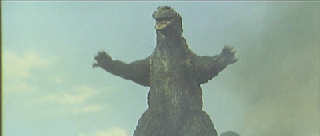

# What are they good for?

- `ShuffledMux`: few streamers, random order, low memory
- `ChainMux`: many streamers, non-random order
- `RoundRobinMux`: few streamers, non-random order, low memory
- `StochasticMux`: many streamers, random order

# How does StochasticMux work?

1. Set a working set size `n_active`
2. Set a `rate > 0`
3. Activate `n_active` streamers
4. Draw samples at random
5. When a streamer has generated `~Poisson(rate)` samples, replace it

- This is good for **training on large datasets**!

# Validation in 2.0

- Val/Test: you want deterministic samples for comparison
- `ChainMux` is good for this

In [ ]:
def data_val(filename):
    features, labels = load(filename)
    
    # Generate finite, deterministic samples
    for x, y in zip(features, labels):
        yield dict(X=x, Y=y)
        
val_streams = [pescador.Streamer(data_val, fn) for fn in VAL_FILES]
val_mux = pescador.ChainMux(val_streams)

model.fit_generator(...,
                    validation_data=val_mux,
                    validation_steps=N)

Note: you need to be able to calculate `N`!!

# Advanced topics: mux composition!

- Class-balanced sampling
- For each class, make a `StochasticMux`
- Collect them with a `ShuffledMux` to balance samples
- You can change the sampling weights easily:
  - `ShuffledMux(streams, weights=[0.5, 0.25, 0.25])`

# Advanced topics: parallel processing!

- `ZMQStreamer` takes a `Streamer` and runs it in the background
- Usually you want a `ZMQStreamer(Mux(...))`
  - not `Mux(ZMQStreamer(...))`
- Still not fully asynchronous :(, but it can reduce latency

# Advanced topics: maps!

- `Streamers` usually make dictionaries of examples
- Sometimes you need tuples (keras) or minibatches (sklearn)
- `pescador.maps` provides helper-wrappers for these ops

# More on StochasticMux

- How to set parameters?
- `rate` should be small
- `n_active` should be large
- This gives a better approximation to `ShuffledMux` (ideal)

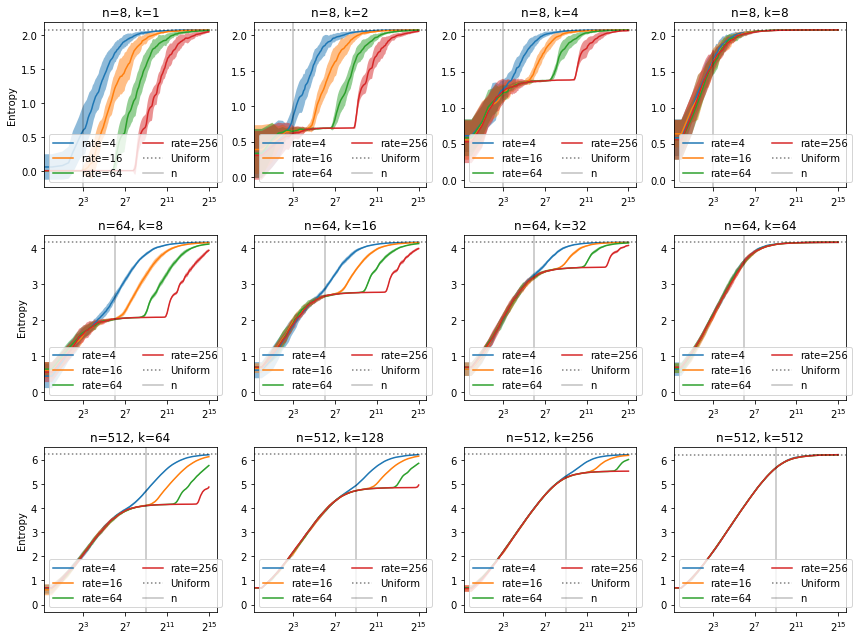